In [ ]:
!pip install pennylane

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 53.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 42.1 MB/s eta 0:00:00


In [ ]:
!pip install scipy

In [ ]:
!pip install pandas

# To Read
In this challenge, we created two algorithms: one classical and one quantum. The reason for this is to compare the responses of the quantum algorithm with the classical one. The VQE algorithm was explained in the previous exercise. Here, what changes are the functions we use to optimize the circuit and the ansatz as well. We did it this way to vary the response and also to understand how different methods from different libraries work.

**Summary:**

1. Quantum algorithm (the function run_vqe(h) will provide the answer to the challenge)
2. Classical algorithm
3. Comparing the algorithms



In [33]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as scipy
from tqdm import tqdm
from scipy.sparse.linalg import eigs,eigsh
import pennylane as qml
from pennylane import numpy as pnp

# Quantum Algorithm Section

In [34]:


def create_hamiltonian(h, N):
    """
    Function to create a Hamiltonian for a spin chain with periodic boundary conditions.

    Args:
        h (float): Magnetic field strength.
        N (int): Number of spins in the chain.

    Returns:
        Hamiltonian: The Hamiltonian representing the spin chain.

    The Hamiltonian consists of:
    - ZZ interaction terms with periodic boundary conditions.
    - X terms representing the effect of the external magnetic field.
    """
    coeffs = []
    ops = []

    # ZZ terms with periodic boundary conditions
    for i in range(N):
        coeffs.append(-1.0)
        ops.append(qml.PauliZ(wires=i) @ qml.PauliZ(wires=(i+1)%N))

    # X terms (magnetic field)
    for i in range(N):
        coeffs.append(-h)
        ops.append(qml.PauliX(wires=i))

    H = qml.Hamiltonian(coeffs, ops)
    return H

def ansatz(params, N):
    """
    Function to define the quantum circuit ansatz for the VQE.

    Args:
        params (array): Array of parameters for the ansatz.
        N (int): Number of qubits (spins) in the system.

    The ansatz uses Strongly Entangling Layers from PennyLane's template library.
    """
    qml.templates.StronglyEntanglingLayers(params, wires=range(N))

def run_vqe(h):
    """
    Function to run the Variational Quantum Eigensolver (VQE) algorithm to find the ground state energy.

    Args:
        h (float): Magnetic field strength.

    Returns:
        energy (float): Final optimized energy (ground state energy).
        params (array): Optimized parameters after VQE execution.
        ground_state (array): Final statevector of the system after optimization.
    """
    N = 4  # Number of spins (qubits)

    # Create the Hamiltonian for the system
    H = create_hamiltonian(h, N)

    # Set up the quantum device
    dev = qml.device('default.qubit', wires=N, shots=None)

    @qml.qnode(dev)
    def circuit(params):
        """
        Quantum node that executes the ansatz and returns the expectation value of the Hamiltonian.

        Args:
            params (array): Parameters for the ansatz.

        Returns:
            float: Expectation value of the Hamiltonian.
        """
        ansatz(params, N)
        return qml.expval(H)

    # Define the number of layers in the ansatz
    num_layers = 4

    # Initialize parameters randomly
    params = pnp.random.normal(0, pnp.pi, size=(num_layers, N, 3), requires_grad=True)

    # Set up the optimizer
    optimizer = qml.AdamOptimizer(stepsize=0.05)
    max_iterations = 500
    convergence_tol = 1e-04

    # Track the energy throughout the optimization
    energy = [circuit(params)]
    for n in range(max_iterations):
        # Perform an optimization step
        params = optimizer.step(circuit, params)
        energy.append(circuit(params))

        # Check for convergence
        if pnp.abs(energy[-1] - energy[-2]) < convergence_tol:
            break

    # After optimization, obtain the final state
    @qml.qnode(dev)
    def final_state(params):
        """
        Quantum node that prepares the final state using the optimized parameters.

        Args:
            params (array): Optimized parameters for the ansatz.

        Returns:
            array: Final statevector of the system.
        """
        ansatz(params, N)
        return qml.state()

    ground_state = final_state(params)

    return energy[-1], params, ground_state


# Result of the VQE for a given h parameter

In [35]:
h = 1
Energy = run_vqe(h)[0]
print("The energy converged was ",Energy)

The energy converged was  -4.809885849116351


# Classical Algorthm Section

**This is not part of the exercise. But we did it just for comparison at the end**





In [44]:
# Definition of Pauli matrices
pauli_x = np.array([[0,1],[1,0]])
pauli_y = np.array([[0,-1j],[1j,0]])
pauli_z = np.array([[1,0],[0,-1]])

N = 4

def Opi(O,i, N):
  """
    Embeds the operator 'O' into the tensor product space at position 'i' out of 'N' qubits.

    Args:
        O (array): A 2x2 matrix representing a quantum operator.
        i (int): Position index for the operator.
        N (int): Total number of qubits.

    Returns:
        array: A 2**N x 2**N matrix representing the operator 'O' embedded in a larger Hilbert space.
    """
  if(i<N):
        return scipy.linalg.kron(scipy.linalg.kron(np.identity(2**i), O),np.identity(2**(N-1-i)))
  elif(i==N):
        j=0
        return scipy.linalg.kron(scipy.linalg.kron(np.identity(2**j), O),np.identity(2**(N-1-j)))
  elif(i==N+1):
        j=1
        return scipy.linalg.kron(scipy.linalg.kron(np.identity(2**j), O),np.identity(2**(N-1-j)))
# For good pratices the The hamilnoian will be divided in two parts Ising and transverse
def Hamiltonian_Ising(N):
    """
    Generates the Ising model Hamiltonian with periodic boundary conditions for N qubits.

    Args:
        N (int): Number of qubits.

    Returns:
        array: A 2**N x 2**N matrix representing the Ising Hamiltonian.
    """


    Hamiltonian_Ising_matrix =  np.zeros((2**N,2**N))

    for i in range(N):
        Hamiltonian_Ising_matrix+=Opi(pauli_z,i, N)@Opi(pauli_z,i+1, N)

    return Hamiltonian_Ising_matrix


def hamiltonian_transverse(N):

   """
    Generates the transverse field term of the Hamiltonian for N qubits.

    Args:
        N (int): Number of qubits.

    Returns:
        array: A 2**N x 2**N matrix representing the transverse field Hamiltonian.
    """

   Hamiltonian_Transverse_matrix = np.zeros((2**N,2**N))

   for i in range(N):
      Hamiltonian_Transverse_matrix += Opi(pauli_x,i, N)

   return Hamiltonian_Transverse_matrix

# Creation of Hamiltonian components
Hamiltonian_Ising = Hamiltonian_Ising(N)
Hamiltonian_Transverse = hamiltonian_transverse(N)

def Hamiltonian_total(g,J=1):
  """
    Combines the Ising and transverse Hamiltonians into a total Hamiltonian with a coupling constant and a transverse field strength.

    Args:
        g (float): Transverse field strength.
        J (float): Coupling constant of the Ising Hamiltonian (default is 1).

    Returns:
        array: A 2**N x 2**N matrix representing the total Hamiltonian.
    """
  return -J*(Hamiltonian_Ising+g*Hamiltonian_Transverse)

In [45]:
# Initialize the array of transverse field values
transverse_field = np.arange(0, 1, 0.1)

#Prepare a DataFrame to store results from the classical calculation
ground_state = pd.DataFrame()
ground_state['G'] = []
ground_state['Energy'] = []
ground_state['Ground State'] = []


for i in transverse_field:
    Hamiltoniano = Hamiltonian_total(g=i)
    eigenvalues, eigenvectors = np.linalg.eig(Hamiltoniano)
    Ground_state = eigenvectors[:,np.argmin(eigenvalues)]
    minor_energy = eigenvalues.min()
    ground_state_list = [i,minor_energy,Ground_state]
    ground_state.loc[len(ground_state)] = pd.Series(ground_state_list,index=ground_state.columns).values

ground_state_energy_real = [energy.real for energy in ground_state['Energy']]

#Prepare a DataFrame to store results from the Quantum calculation

ground_state_variational = pd.DataFrame()

ground_state_variational['G'] = []
ground_state_variational['Energy'] = []
ground_state_variational['Ground State'] = []


for i in transverse_field:
    energia, params_otimizados, estado_ground = run_vqe(i)

    ground_state_variational_list = [i,energia,estado_ground]
    ground_state_variational.loc[len(ground_state_variational)] = pd.Series(ground_state_variational_list,index=ground_state_variational.columns).values


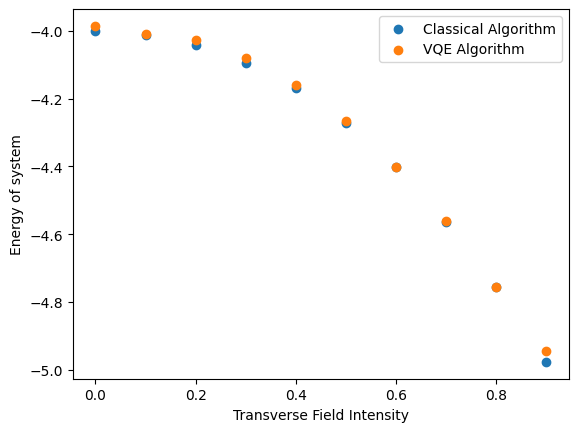

In [46]:
plt.scatter(ground_state['G'], ground_state_energy_real, label= 'Classical Algorithm')
plt.scatter(ground_state_variational['G'],ground_state_variational['Energy'], label = 'VQE Algorithm')
plt.xlabel('Transverse Field Intensity')
plt.ylabel('Energy of system')
plt.legend()
plt.savefig('VQE_figure')